In [1]:
from google.colab import drive
import os
import pandas as pd
from skimage import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil
from skimage.morphology import convex_hull_image, area_closing,binary_dilation
import warnings 
warnings.simplefilter("ignore")

In [3]:
drive.mount("/content/drive")
path_data =  "/content/drive/My Drive/Challenge"

Mounted at /content/drive


# Segmentation

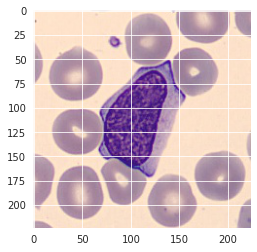

In [4]:
image = np.array(Image.open(path_data+"/trainset/P0/000012.jpg"))
sns.set_style('darkgrid')
plt.imshow(image)

### HSV decomposition

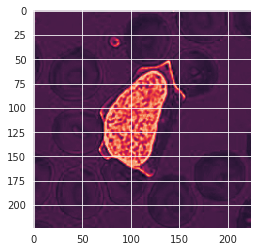

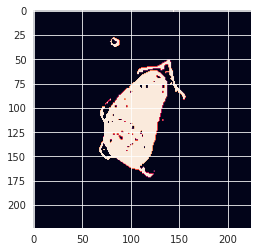

In [5]:
image_S = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:,:,1]
plt.imshow(image_S)
plt.show()

a = 90
image_S[image_S>=a] = 255
image_S[image_S<a] = 0
plt.imshow(image_S)
plt.show()

### K-means 

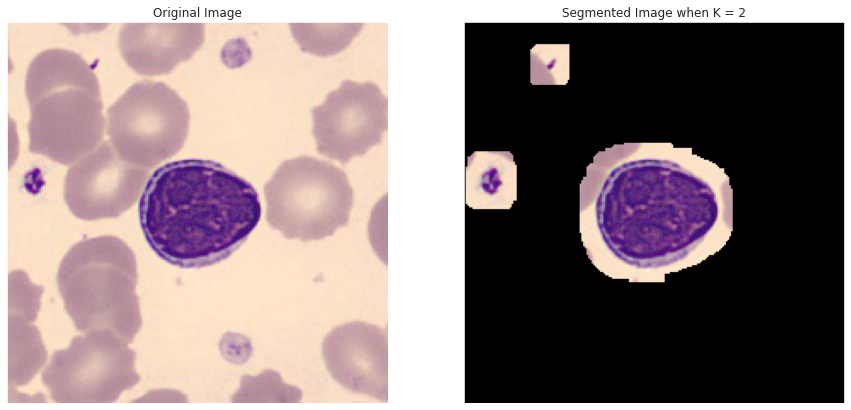

In [ ]:
import time 
K = 2

def K_means_seg(path2img):
  image = np.array(Image.open(path2img))
  image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:,:,1]
  vectorized = image_hsv.reshape((-1))

  vectorized = np.float32(vectorized)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

  attempts=3
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((image_hsv.shape))

  result_image[result_image == np.min(result_image)] = False

  result_image[result_image == np.max(result_image)] = True


  result_image = binary_dilation(result_image , selem=np.ones((20,20)))
  result_image = Image.fromarray(np.array(cv2.bitwise_and(image ,image ,mask = np.uint8(result_image))))

  return result_image

path2img = path_data+"/testset/P108/000000.jpg"

result_image = K_means_seg(path2img)


image = np.array(Image.open(path2img))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(image)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

### Create database of segmented images

In [6]:
os.listdir(path_data+"/testset/")
for folder in os.listdir(path_data+"/testset/"):
  if 'csv' not in folder:
    for file in os.listdir(path_data+"/testset/" + folder):
      result = K_means_seg(path_data+"/testset/" + folder +"/" + file)
      try:
        result.save(path_data+"/testset_seg/" + folder +"/" + file)
      except OSError:
        os.mkdir(path_data+"/testset_seg/"+ folder)
        result.save(path_data+"/testset_seg/" + folder +"/" + file )

# Feature extraction

### Data processing

In [ ]:
path_data =  '/content/drive/My Drive/Challenge'
path_file = '/content/drive/My Drive/'
train_csv = pd.read_csv(path_data+"/trainset/trainset_true.csv")  
test_csv = pd.read_csv(path_data+"/testset/testset_data.csv")  
train_csv

In [ ]:
def csv_processing(features):
  def calculate_age(born):
    today = date.today()
    try:
      [day, month, year] = [int(i) for i in born.split("/")]
    except:
      [day, month, year] = [int(i) for i in born.split("-")]
    return today.year - year - ((today.month, today.day) < (month, day))

  features["DOB"] = features["DOB"].apply(calculate_age)
  features["GENDER"] = features["GENDER"].apply(lambda s:0 if s=='M' else 1)

  features["model_output"] = [0]*len(features)

  return features 

train_csv_preprocessed = csv_processing(train_csv)
test_csv_preprocessed = csv_processing(test_csv)

In [ ]:
# img_size = 224
# fileName = 'train_data_h.h5'
# numOfSamples = len(train_csv)
# with h5py.File(fileName, 'a') as out: 
#   for idx in range(len(train_csv)):
#     patient = train_csv.iloc[idx, 0]
#     #out.create_dataset(patient,(len( os.listdir(path_data+"/trainset/"+patient) ),img_size ,img_size,3),dtype='u1')
#     images=[]
#     for img in os.listdir(path_data+"/trainset/"+patient):
#       imagee = Image.open(path_data+"/trainset/"+patient+"/"+img) 
#       images.append(np.asarray(imagee) )
#     out[patient]= np.asarray(images) 
#     if idx%10==0:
#       print(idx,'/',len(train_csv))

In [ ]:
f_train = h5py.File(path_data + '/train_data_h.h5', 'r')
f_val = h5py.File(path_data + '/val_data_h.h5', 'r')
f_test = h5py.File(path_data + '/test_data_h.h5', 'r')

In [ ]:
class Lympho_Dataset(Dataset):

    def __init__(self, file, csv_file , transform=None):
        self.data = file
        self.transform = transform
        self.csv_data = csv_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        patient = list(self.data.keys())[idx]
        images = []
        for img in self.data[patient]:
            if self.transform:
              img = self.transform(img)
            images.append(img)

        target = torch.tensor(int(self.csv_data.loc[self.csv_data["ID"]==patient]['LABEL']))

        return images, target, patient

### Feature extraction via model trained on blood cells

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

img_size = 128   ## original 224
train_data_transforms = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(30, fill=None),
    transforms.ToTensor(),
])

test_data_transforms = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
])

trainset = Lympho_Dataset(file = f_train, csv_file=train_csv_preprocessed, transform=train_data_transforms)
valset = Lympho_Dataset(file = f_val,csv_file=train_csv_preprocessed, transform=train_data_transforms)
testset = Lympho_Dataset(file = f_test, csv_file=test_csv_preprocessed, transform=test_data_transforms)

In [ ]:
all_data_csv = train_csv_preprocessed
all_data = Lympho_Dataset(file=f_train, csv_file=all_data_csv, transform=train_data_transforms)

In [ ]:
class Net(nn.Module):
    def __init__(self, pretrained_model):
        super(Net, self).__init__()
        self.pretrained = torch.nn.Sequential(*list(pretrained_model.children())[:-1])
        self.input_size = pretrained_model.fc.in_features

        self.fc = nn.Sequential(
               nn.Dropout(p=0.5),
               nn.Linear(self.input_size, 1000),
               nn.Dropout(p=0.5),
               nn.ReLU(inplace=True),
               nn.Linear(1000, 4))


    def forward(self, x):
        x = self.pretrained(x)
        x = x.view(x.size()[0],-1)
        x = self.fc(x)
        return x

In [ ]:
def train_rep_model(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean').cuda()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def validation_rep_model():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

pre_model = models.resnet50(pretrained=True)

ct = 0
for child in pre_model.children():
  ct += 1
  if 0<ct<5:
    for param in child.parameters():
        param.requires_grad = False

model = Net(pre_model)

model.cuda()

train_loader = torch.utils.data.DataLoader(data_train,batch_size=64, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(data_val,batch_size=16, shuffle=True, num_workers=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)


for epoch in range(21):
  scheduler.step()

  for param_group in optimizer.param_groups:
          print("{}/{} Current learning rate is: {}".format(epoch, 20, param_group['lr']))      
          
  train_rep_model(epoch)
  validation_rep_model()
  model_file = path_data + '/model_blood_data_set_3.pth'
  torch.save(model.state_dict(), model_file)


In [ ]:
device = 'cuda'
pretrained = Net(pre_model)
pretrained.load_state_dict(torch.load(path_data + '/model_blood_data_set_3.pth'))
model = torch.nn.Sequential(*list(pretrained.children())[:-1])
model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

### Feature extraction via auto-encoder

In [ ]:
class ED_Dataset(Dataset):

    def __init__(self,path_imgs ,  path_msks , transform=None):
        self.transform = transform
        self.img_files = [f for f in os.listdir(path_imgs)]

        self.path_imgs = path_imgs
        self.path_msks = path_msks

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.path_imgs +'/' + self.img_files[idx])
        if self.transform:
            img = self.transform(img)
        return img

path_imgs = path_data + '/for_encoder/images'
data_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    ])
ed_dataset = ED_Dataset(path_imgs ,path_seg, data_transforms )
loader = torch.utils.data.DataLoader(ed_dataset,batch_size=1, shuffle=False, num_workers=1)

In [ ]:
class Encoder(nn.Module):
  def __init__(self, ndf = 4):
    super(Encoder, self ).__init__()

    self.model = nn.Sequential(nn.Conv2d(3, ndf, 4, bias=False),
                              #nn.ReLU(inplace=True),
                              nn.AvgPool2d(kernel_size=2 , stride = 2),
                              nn.Conv2d(ndf, ndf * 2,4, bias=False),
                              nn.ReLU(inplace=True),
                              nn.BatchNorm2d(ndf * 2),
                              nn.AvgPool2d(kernel_size = 3 , stride = 3),
                              nn.Conv2d(ndf * 2, ndf * 4, 4 , bias=False),
                              nn.ReLU(inplace=True),
                              nn.BatchNorm2d(ndf * 4),
                              nn.AvgPool2d(kernel_size=2 , stride = 2),
                              nn.Conv2d(ndf * 4, ndf * 8, 4,bias=False),
                              nn.ReLU(inplace=True),
                              nn.BatchNorm2d(ndf * 8),
                              nn.AvgPool2d(kernel_size=2 , stride = 2),
                              )
  def forward(self,x):
    out = self.model(x)
    return out

class Decoder(nn.Module):
  def __init__(self,im_dim = 64, z_dim = 3200, ngf = 4 , hidden_dim = 2000):
    super(Decoder, self).__init__()

    self.model = nn.Sequential(
                                nn.ConvTranspose2d(ngf * 64, ngf * 32, 3, 2, 1, bias=False),
                                nn.BatchNorm2d(ngf * 32),
                                nn.ReLU(True),
                                nn.ConvTranspose2d(ngf * 32, ngf * 16, 3, 2, 1, bias=False),
                                nn.BatchNorm2d(ngf * 16),
                                nn.ReLU(True),
                                nn.ConvTranspose2d(ngf * 16, ngf * 8, 3, 2, 1, bias=False),
                                nn.BatchNorm2d(ngf * 8),
                                nn.ReLU(True),
                                nn.ConvTranspose2d( ngf * 8, ngf * 4, 3, 2, 1, bias=False),
                                nn.BatchNorm2d(ngf * 4),
                                nn.ReLU(True),
                                nn.ConvTranspose2d( ngf * 4, ngf *2 , 3, 2, 1, bias=False),
                                nn.BatchNorm2d(ngf*2),
                                nn.ReLU(True),
                                nn.ConvTranspose2d( ngf*2,ngf, 3, 3, 1, bias=False),
                                nn.BatchNorm2d(ngf),
                                nn.ReLU(True),
                                nn.ConvTranspose2d( ngf, 3, 3, 3, 1, bias=False),
                                nn.Sigmoid(),
                              )
    
  def forward(self,x):
    out = self.model(x)
    return out

  
class Encoder_Decoder(nn.Module):
  def __init__(self,ndf = 256):
    super(Encoder_Decoder, self).__init__()

    self.encoder = Encoder(ndf)

    self.decoder = Decoder(ngf = ndf//8)

  def forward(self,x):
    y = self.encoder(x)
    out = self.decoder(y)
    out = F.interpolate(out, size=x.shape[-2:], mode='bilinear', align_corners=False)
    return out , y.view(y.size(0),-1)


In [ ]:
device = 'cuda'
criterion = nn.BCELoss(reduction='mean')

def train_ed_model(epoch):
    model.train()
    for idx, img in enumerate(loader):
        optimizer.zero_grad()
        img = img.to(device)
        output , _ = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        if idx %100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTLoss: {:.6f}'.format(
                  epoch, idx, len(loader),
                  100. * idx / len(loader), loss.data.item() ))
          plt.imshow(img[0].squeeze(0).clone().cpu().permute(1, 2, 0))
          plt.show()
          plt.imshow(output[0].squeeze(0).clone().detach().cpu().permute(1, 2, 0))
          plt.show()


model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(21):
  scheduler.step()
  for param_group in optimizer.param_groups:
          print("{}/{} Current learning rate is: {}".format(epoch, 20, param_group['lr']))      
  train_ed_model(epoch)
  model_file = path_data + '/model_ed_8192.pth'
  torch.save(model.state_dict(), model_file)

### Saving features

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    ])

trainset = Lympho_Dataset(file = f_train, csv_file=train_csv, transform=data_transforms)
valset = Lympho_Dataset(file = f_val,csv_file=train_csv, transform=data_transforms)
testset = Lympho_Dataset(file = f_test,csv_file=test_csv, transform=data_transforms)

data_train = pd.DataFrame()
device = 'cuda'
model = Encoder_Decoder()

model.load_state_dict(torch.load(path_data + '/model_ed_8192.pth'))
model.eval()
model.to(device)
data = trainset
ii = 0

for i, (imgs , target, patient) in enumerate(data):
    features = []
    for image in imgs:
      _ , feature= model(image.unsqueeze(0).to(device))
      feature = feature.view(-1)
      feature = feature.cpu().detach().numpy()
      features.append(feature)
    features = np.array(features)
    for j in range(features.shape[0]):
      dic = {'ID_image' : ii+j , 'ID_patient' : patient , 'patient_label' : int(target.numpy()) }
      for k in range(features.shape[1]):
        dic[f'image_features_{k}'] = features[j][k]
      data_train = data_train.append(dic,ignore_index=True)
    ii +=len(imgs)
    if i%10 == 0 :
      print(i,'/',len(data))
data_train.to_csv(path_data + '/test_features_8192.csv')
data_train